# Детекция и сегментация автомобильных номеров 

In [4]:
import os 
import gc 
import json 
import tqdm 

import torch 
from torch.utils.data import Dataset, DataLoader

import torchvision 
from torchvision import models 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor 
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor 
from torchvision import transforms 

import numpy as np 
import PIL 
from PIL import Image, ImageDraw 
import cv2 
import matplotlib.pyplot as plt 
from matplotlib.path import Path 
import seaborn as sns 

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
!unzip /content/drive/MyDrive/archive.zip 

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/train/5499.bmp     
  inflating: data/train/55.bmp       
  inflating: data/train/550.jpg      
  inflating: data/train/5500.jpg     
  inflating: data/train/5501.bmp     
  inflating: data/train/5502.jpg     
  inflating: data/train/5503.jpg     
  inflating: data/train/5504.jpg     
  inflating: data/train/5505.jpg     
  inflating: data/train/5506.jpg     
  inflating: data/train/5507.jpg     
  inflating: data/train/5508.jpg     
  inflating: data/train/5509.jpg     
  inflating: data/train/551.jpg      
  inflating: data/train/5510.jpg     
  inflating: data/train/5511.jpg     
  inflating: data/train/5512.jpg     
  inflating: data/train/5513.jpg     
  inflating: data/train/5514.jpg     
  inflating: data/train/5515.jpg     
  inflating: data/train/5516.jpg     
  inflating: data/train/5517.jpg     
  inflating: data/train/5518.jpg     
  inflating: data/train/5519.bmp     
  inflating: data/tr

#Вспомогательные функции

In [7]:
# https://copyprogramming.com/howto/how-does-approxpolydp-and-epsilon-parameter-work
# Взято отсюда: https://stackoverflow.com/questions/13028961/how-to-force-approxpolydp-to-return-only-the-best-4-corners-opencv-2-4-2
# Бинарный поиск для приближения(аппроксимации) предсказанной маски
# Алгоритм не определяет формы, он упрощает контуры.
# Он удаляет точки, которые очень мало (эпсилон) влияют на форму контура. 
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('Не удалось упроситить контур')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Взято отсюда: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
# Делаем трансформацию ракурса для изображения
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

# Сортируем точки (чтобы было видо где верхняя лева я и т.д.)
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None, show_prediction=True):
  
    my_transforms = transforms.Compose([
    transforms.ToTensor()
    ])
  
    img = Image.open(file) #загружаем изображение
    img_tensor = my_transforms(img) # трансформируем изображение в тензор
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0] # предсказания модели

    # если кол-во цветов не указано смотрим количество выходных признаков(у нас их 2)
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors) # наша палитра
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB) #загружаем изображение opencv
    h, w = img.shape[:2] # высота ширина
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype) # черное изображения размера оригинала
    blackImg[:,:] = (0, 0, 0)

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist()) # достаём координаты
        label = int(prediction['labels'][i].cpu()) # метка
        score = float(prediction['scores'][i].cpu()) # вероятности
        mask = prediction['masks'][i][0, :, :].cpu().numpy() #маска
        name = id_to_name[label] # название класса
        color = palette[label] # цвет для бокса

        if verbose:
            if score > thresh:
                print ('Класс: {}, Вероятность: {} %'.format(name, round(score,4)))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max] # вырезаем нашу рамку из исходника
            print('Рамка:')
            show_image(crop_img, figsize=(10, 2))

            contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1) # ищем контур на маске
            approx = simplify_contour(contours[0], n_corners=4) # упрощаем контур

            # находим углы для изменения ракурса
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            # points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Рамка с изменённым ракурсом:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))

            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            show_image(mask, reverse=False)


    show_image(image)
    if show_prediction:
      return prediction

# Вывести пикчу
def show_image(image, figsize=(9, 7), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()


def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)

# Константы и разбиение данных


In [8]:
DATA_PATH = './data/' # путь к нашему датасету
TRAIN_SIZE = 0.9 # размер обучающей выборки
BATCH_SIZE = 2 # размер пакета (2 фотки)
DETECTOR_MODEL_PATH = 'detector.pt' # название для сохранения обученной модели

all_marks = load_json(os.path.join(DATA_PATH, 'train.json')) # считываем метки из json файла
test_start = int(TRAIN_SIZE * len(all_marks)) # индекс элемента для среза на обучение и валидацию
train_marks = all_marks[:test_start] # обучающая выборка 
val_marks = all_marks[test_start:] # валидационная выбока

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # на чём считаем (cpu/gpu)

# Подготовка данных для модели

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

In [ ]:
class DetectionDataset(Dataset):
    # инициализация класса
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
    
    # загружаем/возвращаем выборку по указаному индексу
    def __getitem__(self, idx):
        item = self.marks[idx] # элемент
        img_path = f'{self.img_folder}{item["file"]}' # путь к элементу
        img = Image.open(img_path).convert('RGB') # загружаем изображение
        w, h = img.size # размер изображения
        
        box_coords = item['nums'] # инфа о элемнте
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1]) # левый нижний угол бокса
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1]) # правый верхний угол бокса
            boxes.append([x0, y0, x2, y2])
            labels.append(1) # метка
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
        
        # преобразуем списки в тензор
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        # словарь для удобства
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        # делаем трансформацию, если указано
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)

Создаём классы

In [ ]:
# трансормация в тензор
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

# создаём класс для обучающей выборки
train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='data/', 
    transforms=my_transforms
)

# создаём класс для валидационной выборки
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='data/', 
    transforms=my_transforms
)

NameError: ignored

Подготавливаем наши данные для обучения

https://pytorch.org/docs/stable/data.html

In [ ]:
# функция создания пакета
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, #наш класс датасета
    batch_size=BATCH_SIZE, # размер пакета
    drop_last=True, # отбрасываем последний неполный пакет
    num_workers=4, # многопроцессорная загрузка данных (4 рабочих процесса загрузчика)
    collate_fn=collate_fn, # функция создания пакета
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn, 
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Обучение модели

## 1. Создание модели
У нас есть данные о 4 точках. Эти 4 точки - почти всегда не прямоугольник, а произвольный четырехугольник. Будем предсказывать:

- bounding box, который окружает точки (детекция)
- маску, заполненную тем, что внутри 4-х точек (сегментация)

Поэтому, возьмем maskrcnn. Будем обучать несколько последних слоёв. 

https://habr.com/ru/post/579050/

https://habr.com/ru/post/665300/

In [9]:
# "Базовые" веса обученные на датасетах (resnet50 — IMAGENET1K_V2, MaskRCNN_ResNet50_FPN — COCO_V1)
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models import ResNet50_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
weights_backbone = ResNet50_Weights.DEFAULT

In [10]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        weights=weights,
        weights_backbone=weights_backbone,
        num_classes=91, # вроде как это по дефолту, но на всякий укажем
    )

    #Исходная модель рассчитана на детекцию 91 класса. 
    #Нам нужно детектировать только один объект, поэтому необходимо заменить box_predictor внутри модели. 
    #Меняем количество выходов на 2, потому что нулевым классом должен быть фон.
    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features 
    
    box_predictor = FastRCNNPredictor(in_features, num_classes) # детекция
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes) # сегментация
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних трёх
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model

##Обучение модели
https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [11]:
torch.cuda.empty_cache() # освобождаем всю незанятую кэшированную память
gc.collect() # собираем мусор в памяти
model = get_detector_model() # создаём нашу модель
model.load_state_dict(torch.load(DETECTOR_MODEL_PATH)) # загрузка нашей модели
model.to(device);

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Валидироваться на чем-то нет смысла, ибо лосс перестает падать еще до того момента, как пройдет 1-я эпоха. Т.е. лосс на трейне вполне валидный, ибо модель видит данные в первый раз.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) # Оптимизатор
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True) # Замедляет обучение, если метрика перестаёт улучшаться

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

In [ ]:
#torch.save(model.state_dict(), DETECTOR_MODEL_PATH) # сохранение нашей модели

Класс: Номер машины, Вероятность: 0.9903 %
Рамка:


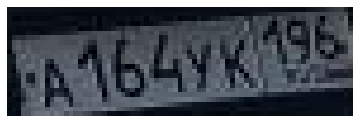

Рамка с изменённым ракурсом:


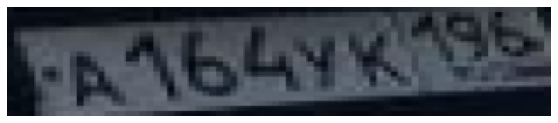

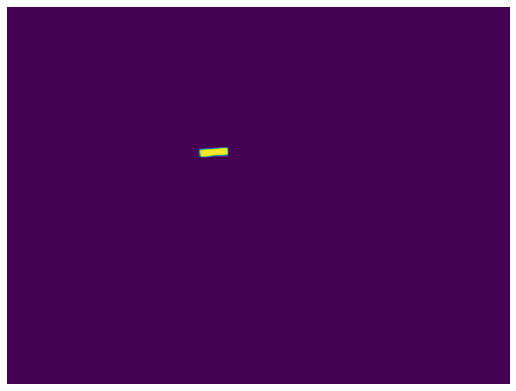

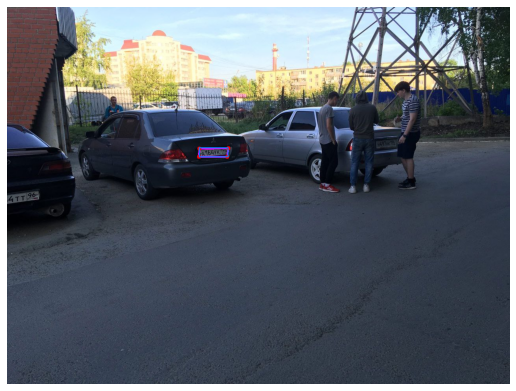

In [12]:
visualize_prediction_plate('img1.png', model, id_to_name={1: 'Номер машины'}, thresh=0.95, show_prediction=False)